In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() != None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
#     print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

In [5]:
dfhw=pd.read_csv("data/01_heights_weights_genders.csv")
print(dfhw.shape)
dfhw.head()

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [6]:

df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

261

In [7]:
df.shape[0]

500

In [8]:
itrain, itest = train_test_split(np.arange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([False,  True, False, False,  True, False, False,  True,  True,
        True])

using mask


c:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\lib\site-packages\sklearn\linear_mo

BEST {'C': 0.01} 0.9233333333333333 {'mean_fit_time': array([0.01455188, 0.00441699, 0.00234532, 0.00167031, 0.00273004,
       0.00394902, 0.00247722, 0.00320745]), 'std_fit_time': array([0.02208797, 0.00724954, 0.00192639, 0.00286694, 0.0014878 ,
       0.00178068, 0.00202793, 0.00161479]), 'mean_score_time': array([0.00039859, 0.0005547 , 0.00146294, 0.00256453, 0.00093045,
       0.00138059, 0.00137715, 0.        ]), 'std_score_time': array([0.00048818, 0.00110941, 0.00135911, 0.00212333, 0.00052792,
       0.00200547, 0.00146922, 0.        ]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}, {'C': 10000}], 'split0_test_score': array([0.91803279, 0.95081967, 0.95081967, 0.95081967, 0.95081967,
       0.95081967, 0.95081967, 0.95081967]), '

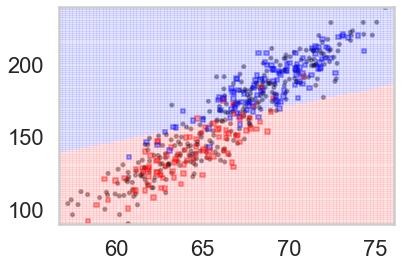

In [9]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [10]:
clflog.predict(Xtest)

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1])

In [11]:
clflog.predict_proba(Xtest)

array([[9.83859457e-01, 1.61405432e-02],
       [4.00503966e-01, 5.99496034e-01],
       [2.02866276e-02, 9.79713372e-01],
       [9.95688334e-01, 4.31166642e-03],
       [4.35777618e-02, 9.56422238e-01],
       [2.40702295e-01, 7.59297705e-01],
       [1.17731614e-01, 8.82268386e-01],
       [9.83472069e-01, 1.65279310e-02],
       [8.82333846e-01, 1.17666154e-01],
       [5.64232375e-03, 9.94357676e-01],
       [9.76691345e-01, 2.33086554e-02],
       [9.95903081e-01, 4.09691891e-03],
       [1.12577846e-02, 9.88742215e-01],
       [9.92636716e-01, 7.36328387e-03],
       [2.91080903e-01, 7.08919097e-01],
       [1.04646533e-02, 9.89535347e-01],
       [1.10643401e-01, 8.89356599e-01],
       [9.95351454e-01, 4.64854591e-03],
       [9.67412486e-01, 3.25875144e-02],
       [5.05237754e-03, 9.94947622e-01],
       [8.50532301e-01, 1.49467699e-01],
       [8.22459059e-03, 9.91775409e-01],
       [6.79103217e-02, 9.32089678e-01],
       [1.91428223e-02, 9.80857178e-01],
       [1.891810

In [12]:
clflog.predict_proba(Xtest)[:,1]

array([1.61405432e-02, 5.99496034e-01, 9.79713372e-01, 4.31166642e-03,
       9.56422238e-01, 7.59297705e-01, 8.82268386e-01, 1.65279310e-02,
       1.17666154e-01, 9.94357676e-01, 2.33086554e-02, 4.09691891e-03,
       9.88742215e-01, 7.36328387e-03, 7.08919097e-01, 9.89535347e-01,
       8.89356599e-01, 4.64854591e-03, 3.25875144e-02, 9.94947622e-01,
       1.49467699e-01, 9.91775409e-01, 9.32089678e-01, 9.80857178e-01,
       9.81081891e-01, 1.00830635e-02, 6.77548414e-01, 5.85817066e-02,
       6.32864562e-01, 9.60300845e-01, 4.94170377e-01, 2.73798723e-01,
       9.95863015e-01, 9.79648262e-01, 8.43581780e-01, 4.76715802e-02,
       9.74572426e-01, 1.70636747e-01, 3.11492953e-01, 4.39195986e-02,
       9.79610088e-01, 1.82957813e-01, 8.24449567e-04, 2.06605154e-01,
       3.22663462e-01, 1.83782551e-01, 9.46886247e-01, 9.74934281e-01,
       2.29719140e-02, 5.60379919e-02, 9.11794843e-01, 4.16069565e-02,
       9.41888345e-01, 2.79268686e-01, 7.87749261e-01, 4.54264139e-01,
      

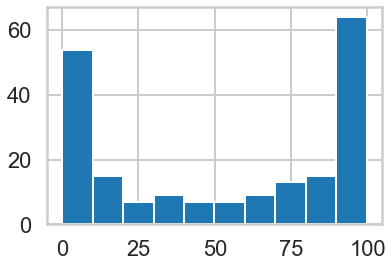

In [13]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

c:\python\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
c:\python\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


TypeError: clabel() got an unexpected keyword argument 'axes'

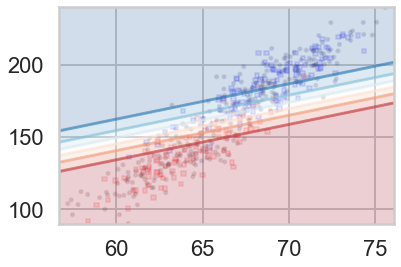

In [14]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [15]:
clflog.score(Xtest, ytest)

0.905

using mask


c:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST {'C': 0.1} 0.9166666666666666 {'mean_fit_time': array([1.72863007e-03, 7.99036026e-04, 4.84046936e-03, 6.50739670e-03,
       4.33350086e-02, 4.04880476e-01, 1.22362089e+00]), 'std_fit_time': array([0.00133813, 0.00159807, 0.00592019, 0.00797908, 0.00827895,
       0.1150404 , 0.58553976]), 'mean_score_time': array([0.00024052, 0.00237303, 0.00019927, 0.        , 0.00312438,
       0.0003994 , 0.00046659]), 'std_score_time': array([0.00048103, 0.00182526, 0.00039854, 0.        , 0.00624876,
       0.00048916, 0.00085959]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.93442623, 0.93442623, 0.93442623, 0.93442623, 0.93442623,
       0.95081967, 0.91803279]), 'split1_test_score': array([0.86885246, 0.86885246, 0.86885246

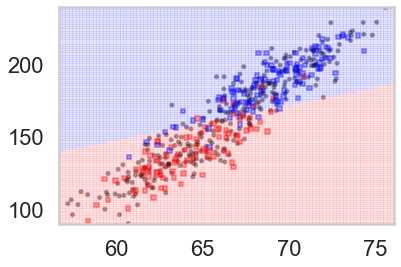

In [16]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [17]:

clfsvm.decision_function(Xtest)

array([-3.21603020e+00,  2.65391483e-01,  2.94214046e+00, -4.24740932e+00,
        2.34152998e+00,  8.43488188e-01,  1.50184880e+00, -3.19757955e+00,
       -1.60572696e+00,  3.94355556e+00, -2.93367558e+00, -4.27944983e+00,
        3.40124947e+00, -3.82109139e+00,  6.39068832e-01,  3.46434290e+00,
        1.55637225e+00, -4.17973720e+00, -2.66998736e+00,  4.02859732e+00,
       -1.38218856e+00,  3.64476819e+00,  1.96988905e+00,  2.99068692e+00,
        2.99666008e+00, -3.58089351e+00,  5.28394693e-01, -2.18605450e+00,
        3.68262551e-01,  2.40860959e+00, -5.72950449e-02, -8.01235600e-01,
        4.18859019e+00,  2.95131978e+00,  1.24422585e+00, -2.34977040e+00,
        2.77026605e+00, -1.26328313e+00, -6.65232149e-01, -2.42732440e+00,
        2.94556065e+00, -1.20778662e+00, -5.52509815e+00, -1.07801785e+00,
       -6.17565469e-01, -1.19032374e+00,  2.17011823e+00,  2.77343123e+00,
       -2.93981283e+00, -2.22492868e+00,  1.76445837e+00, -2.46575508e+00,
        2.10236125e+00, -

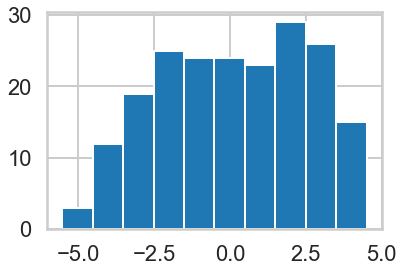

In [18]:
plt.hist(clfsvm.decision_function(Xtest));

c:\python\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
c:\python\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


TypeError: clabel() got an unexpected keyword argument 'axes'

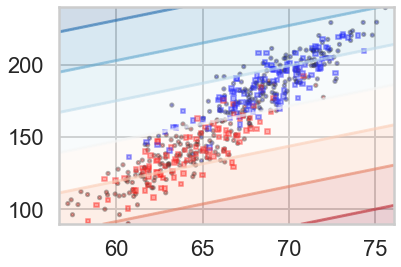

In [19]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

In [20]:
def plot_svc_decision_function(clf, ax=None):
    
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

ValueError: Expected 2D array, got 1D array instead:
array=[56.70266004 89.68540565].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

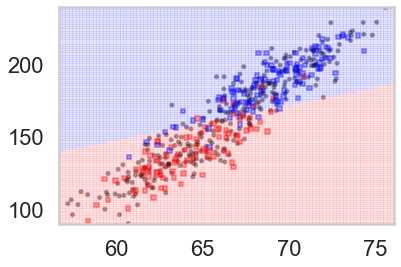

In [21]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

In [23]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[82,  9],
       [10, 99]], dtype=int64)

In [24]:
from sklearn.metrics import classification_report
print (classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90        91
           1       0.92      0.91      0.91       109

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200



In [25]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [26]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[ 53,  38],
       [  1, 108]], dtype=int64)

In [27]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

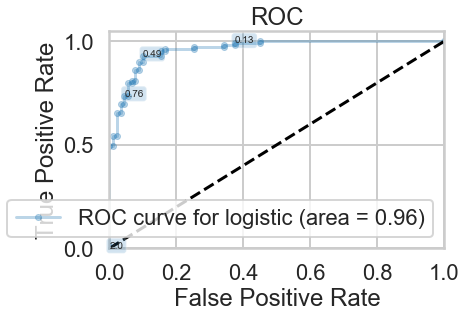

In [28]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

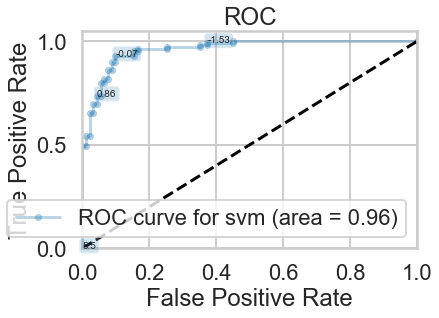

In [29]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)